In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Libraries

In [ ]:
from os import listdir
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
import imutils
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,Dropout,BatchNormalization,ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
yespath="/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset_original/augmented_data/yes"
nopath="/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset_original/augmented_data/no"

In [ ]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

## Load Data

In [ ]:
dir_list=[]
dir_list.append(yespath)
dir_list.append(nopath)
X = []
y = []
image_width, image_height = (240,240)
    
for directory in dir_list:
  for filename in listdir(directory):
    # load the image
      
      image = cv2.imread(directory + '/' + filename)
      #pyplot.imshow(image)
      #print(image.shape)
      # crop the brain and ignore the unnecessary rest part of the image
      image = crop_brain_contour(image, plot=False)
      # resize image
      image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
      # normalize values
      image = image / 255.
      # convert image to numpy array and append it to X
      X.append(np.array(image))
      # append a value of 1 to the target array if the image
      # is in the folder named 'yes', otherwise append 0.
      if directory[-3:] == 'yes':
          y.append(np.array([1]))
      else:
          y.append(np.array([0]))
                
  #X = np.array(X)
  #y = np.array(y)
print(type(X))
print(type(y))

<class 'list'>
<class 'list'>


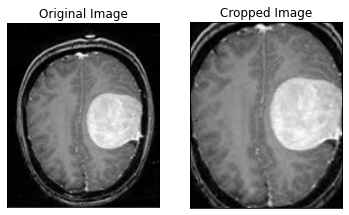

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/brain_tumor_dataset_original/augmented_data/yes/aug_Y1_0_2900.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
X=np.array(X)
y=np.array(y)
X, y = shuffle(X, y)
print(f'Number of examples is: {len(X)}')
print(f'X shape is: {X.shape}')
print(f'y shape is: {y.shape}')

Number of examples is: 2066
X shape is: (2066, 240, 240, 3)
y shape is: (2066, 1)


## Plotting

In [ ]:
def plot_sample_images(X, y, n=20):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

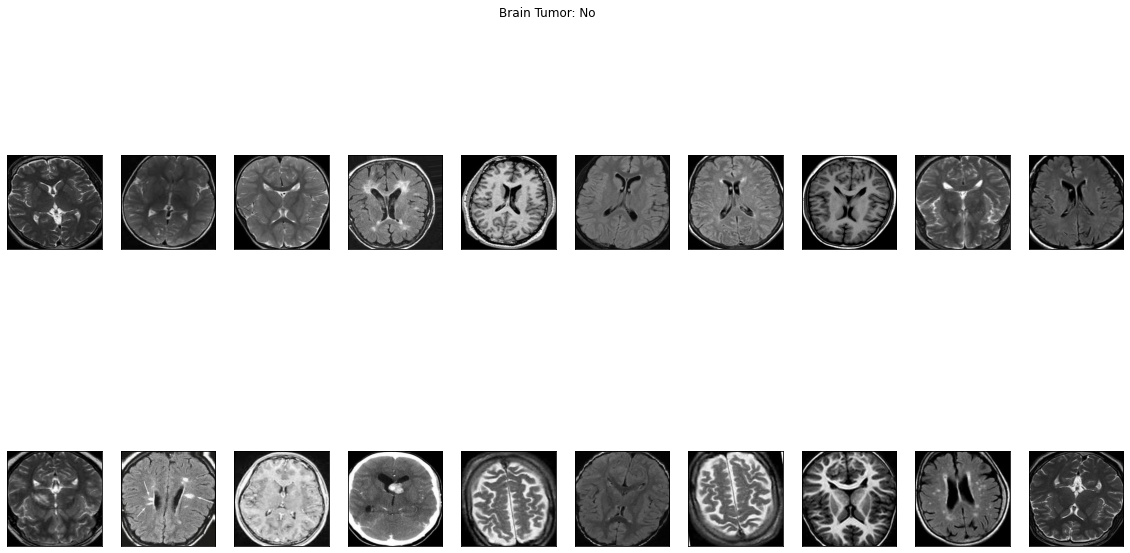

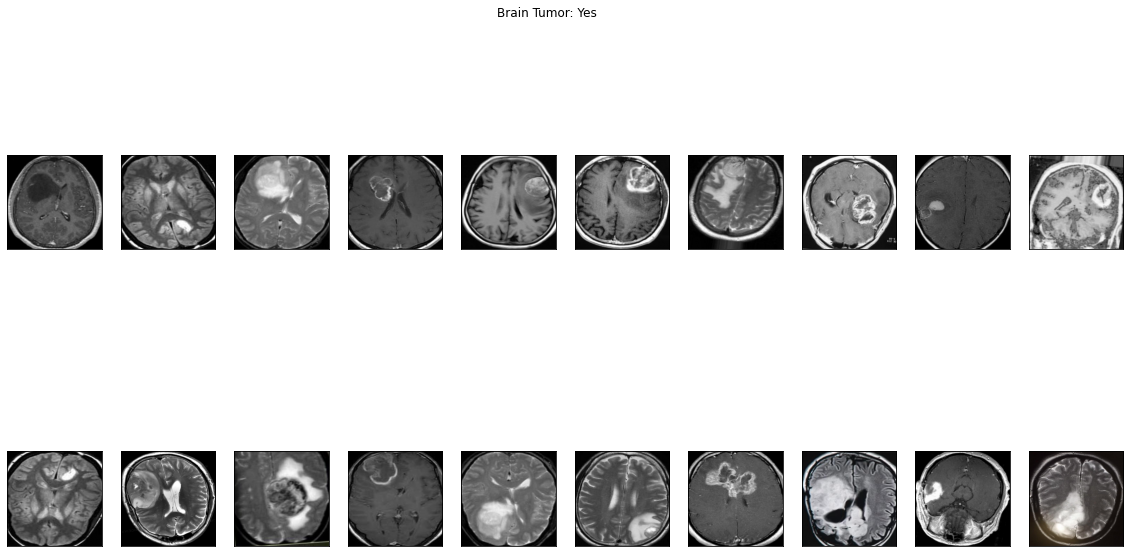

In [ ]:
plot_sample_images(X, y)

## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0,stratify=y)

In [ ]:
print ("number of training examples = " + str(x_train.shape[0]))

print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))

print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1652
number of test examples = 414
X_train shape: (1652, 240, 240, 3)
Y_train shape: (1652, 1)
X_test shape: (414, 240, 240, 3)
Y_test shape: (414, 1)


## Build the Model

In [ ]:
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='he_uniform',input_shape=(240,240,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16,kernel_size=(3,3),padding='same',activation='relu',kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 240, 240, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 240, 240, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 16)      4624      
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 120, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 16)        0

## Model Training

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,y_train,epochs=25,verbose=1,batch_size=32,validation_data=(x_test,y_test))

Epoch 1/25
52/52 [==============================] - 147s 3s/step - loss: 2.6124 - accuracy: 0.5926 - val_loss: 1.7885 - val_accuracy: 0.4662
Epoch 2/25
52/52 [==============================] - 144s 3s/step - loss: 0.5824 - accuracy: 0.6992 - val_loss: 2.7109 - val_accuracy: 0.5169
Epoch 3/25
52/52 [==============================] - 142s 3s/step - loss: 0.4698 - accuracy: 0.7730 - val_loss: 1.8966 - val_accuracy: 0.5556
Epoch 4/25
52/52 [==============================] - 143s 3s/step - loss: 0.3969 - accuracy: 0.8039 - val_loss: 1.6936 - val_accuracy: 0.6063
Epoch 5/25
52/52 [==============================] - 142s 3s/step - loss: 0.3386 - accuracy: 0.8396 - val_loss: 1.6983 - val_accuracy: 0.6353
Epoch 6/25
52/52 [==============================] - 145s 3s/step - loss: 0.2874 - accuracy: 0.8638 - val_loss: 1.0186 - val_accuracy: 0.7198
Epoch 7/25
52/52 [==============================] - 143s 3s/step - loss: 0.2526 - accuracy: 0.8904 - val_loss: 1.1655 - val_accuracy: 0.7512
Epoch 8/25
52

## Accuracy and Loss curve

In [ ]:
def plot_learningCurve(history,epoch):
    epochrange=range(1,epoch+1)
    plt.plot(epochrange,history.history['accuracy'])
    plt.plot(epochrange,history.history['val_accuracy'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend(["train","test"],loc="upper left")
    plt.show()

    plt.plot(epochrange,history.history['loss'])
    plt.plot(epochrange,history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Loss Curve")
    plt.legend(["train","test"],loc="upper left")
    plt.show()

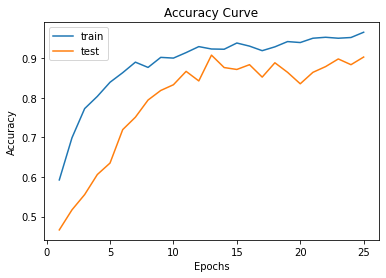

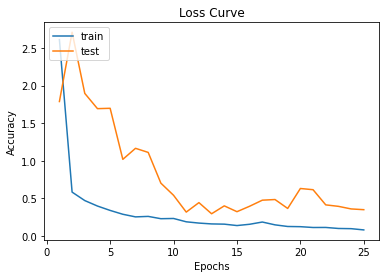

In [ ]:
plot_learningCurve(history,25)

## Model Evaluation

#### Accuracy

In [ ]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9033816456794739


#### Confusion Matrix

In [ ]:

y_pred=model.predict_classes(x_test)
print(confusion_matrix(y_test,y_pred))

[[176  20]
 [ 20 198]]


#### Classification Report

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       196
           1       0.91      0.91      0.91       218

    accuracy                           0.90       414
   macro avg       0.90      0.90      0.90       414
weighted avg       0.90      0.90      0.90       414



## Data Augmentation

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
    Arguments:
        file_dir: A string representing the directory where images that we want to augment are found.
        n_generated_samples: A string representing the number of generated samples using the given image.
        save_to_dir: A string representing the directory in which the generated images will be saved.
    """
    
    #from keras.preprocessing.image import ImageDataGenerator
    #from os import listdir
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [ ]:
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples